In [1]:
install.packages("car")

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zip’, ‘SparseM’, ‘MatrixModels’, ‘data.table’, ‘openxlsx’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’, ‘lme4’




In [2]:
library(dplyr)
library(car)
library(stringr)
library(ggplot2)

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



In [3]:
survey_results <- read.csv("results_last.csv")
df[df==""] <- NA
df[df=="NA"] <- NA

ERROR: Error in df == "": comparison (1) is possible only for atomic and list types


In [4]:
df <- survey_results[8:41]
realNames <- c("Alter","Gender","Job","Einkommen","Bildung","Pendel","Pendel2",
                  "Pendel2Sonst","BahnhofHeim","BahnhofZiel","Ticket","TicketSonst", 
                  "PaketeProJahr","PaketPlatformen","PreisBisher","PreisEinschätzung", 
                  "AufNachhaltig","AufNachhaltigMenge","GeschwBisher", "AufGeschw", 
                  "AufGeschwMenge","Versicherung", "VersicherungSonst", "App",
                  "Tracking","Abholen","GrundNichtAbholen","Transport", 
                  "TransportSpende","TransportGeld","TransportNeinGrund",
                  "TransportBoni","Kommentare","Email")
colnames(df) <- realNames
glimpse(df)

Observations: 131
Variables: 34
$ Alter              <int> 20, 58, 26, 21, 23, 24, 21, 30, 72, 43, 44, NA, 23…
$ Gender             <fct> A1, A2, A2, A1, A2, A1, A1, A1, A1, A2, A2, , A1, …
$ Job                <fct> A2, A3, A2, A2, A2, A3, A2, A2, A3, A3, A3, , A2, …
$ Einkommen          <fct> A2, A4, A3, A2, , A3, A2, A4, A3, A4, A3, , A5, A2…
$ Bildung            <fct> A5, A6, A5, A5, A5, A6, A5, A6, A4, A6, A5, , A4, …
$ Pendel             <fct> A3, A3, A1, A3, A3, A1, A3, A3, A3, A3, A3, , A3, …
$ Pendel2            <fct> , , A4, , , A1, , , , , , , , , , -oth-, , , , , ,…
$ Pendel2Sonst       <fct> , , , , , , , , , , , , , , , 4 mal im Monat (durc…
$ BahnhofHeim        <fct> , , Göttingen , , , Ahrensburg, , , , , , , , , , …
$ BahnhofZiel        <fct> , , Hannover, , , Wandsbek-Gartenstadt, , , , , , …
$ Ticket             <fct> , , A3, , , A1, , , , , , , , , , -oth-, , , , , ,…
$ TicketSonst        <fct> , , , , , , , , , , , , , , , Einzelticket, , , , …
$ PaketeProJahr     

# Auswertung (Teilnehmer):

Warning message:
“Removed 17 rows containing non-finite values (stat_bin).”


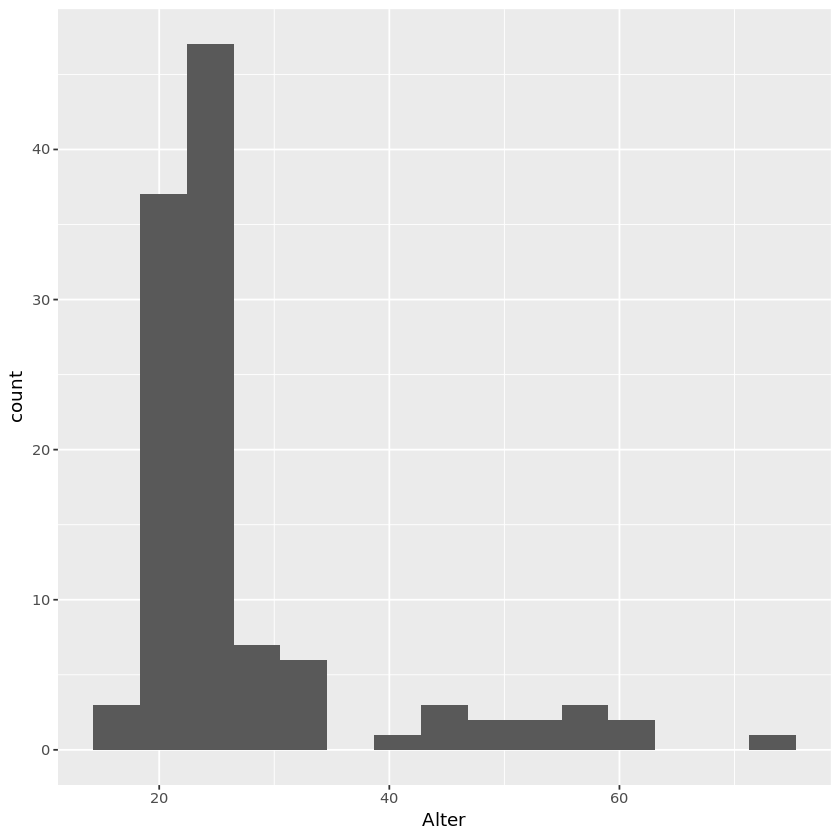

In [5]:
ggplot(df, aes(Alter)) + geom_histogram(bins = 15)

In [6]:
df$Gender <- as.factor(df$Gender)
levels(df$Gender) <- c("NA", "Male", "Female")  # "Divers" hatte keine Einträge
table(df$Gender)
# ggplot(df, aes(Gender)) + geom_bar()


    NA   Male Female 
    17     74     40 


       NA      <500  500-1000 1000-1500 1500-2500     >2500 
       25        20        37        13        18        18 

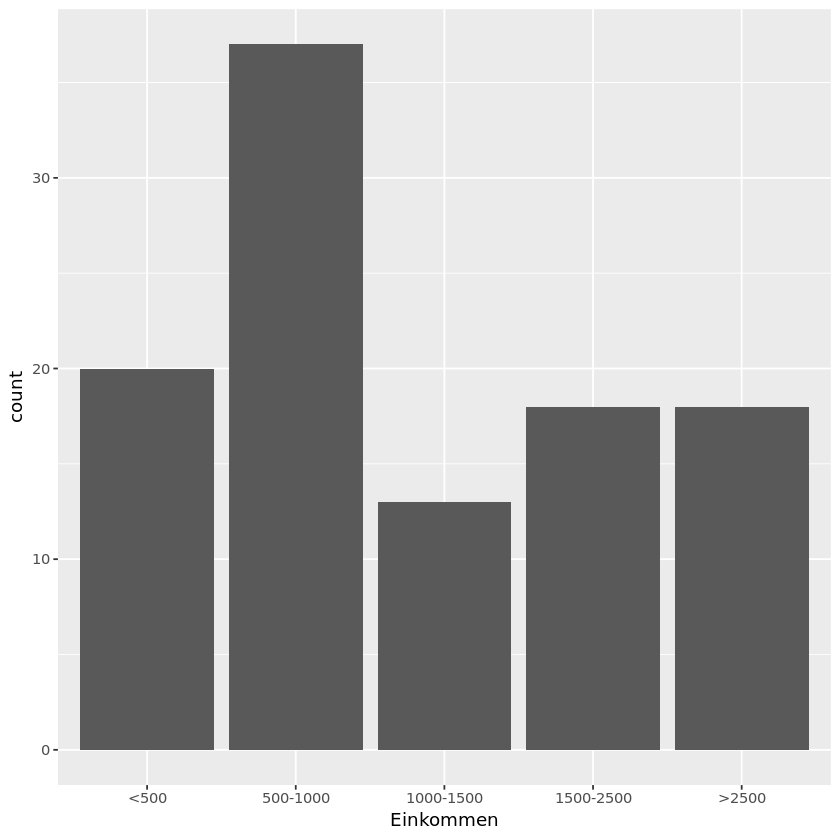

In [7]:
df$Einkommen <- as.factor(df$Einkommen)
levels(df$Einkommen) <- c("NA", "<500", "500-1000", "1000-1500", "1500-2500", ">2500")
table(df$Einkommen)

ggplot(subset(df, Einkommen!="NA"), aes(Einkommen)) + geom_bar()

In [8]:
# Viele Pendler?
df$Pendel <- as.factor(df$Pendel)
levels(df$Pendel) <- c("NA", "Zug", "Anders", "Nein")
table(df$Pendel)

anteilZug <- sum(df$Pendel == "Zug")/sum(df$Pendel != "NA")
print("Anteil zugfahrende Pendler:")
anteilZug

df$Ticket <- as.factor(df$Ticket)
levels(df$Ticket) <- c("NA", "Sonst", "Monat", "Jahr", "Studenten")
# table(df$Ticket)
print("Anteil Studententickets (sehr wenige Daten):")
sum(df$Ticket == "Studenten")/sum(df$Ticket != "NA") # EXTREM wenige Daten -> nicht aussagekräftig


    NA    Zug Anders   Nein 
    17     12     13     89 

[1] "Anteil zugfahrende Pendler:"


[1] 0.1052632

[1] "Anteil Studententickets (sehr wenige Daten):"


[1] 0.1666667

# Auswertung (zentrale Daten):

In [9]:
# Analyse von bisherigen Preisen
df$PreisBisher <- as.factor(df$PreisBisher)
levels(df$PreisBisher) <- c("NA", "<2", "2-4", "4-8", "8-14", ">14")
t <- as.data.frame(table(df$PreisBisher))

n <- sum(df$PreisBisher != "NA")
t$relFreq <- t$Freq/n
t$groupMid <- c(0, 1, 3, 6, 11, 14)
t$mult <- t$relFreq*t$groupMid
t
print("Bisheriger Preis (Arithmetisches Mittel bei gruppierten Daten):")
mittelPreisBisher <- round(sum(t$mult), 2)
mittelPreisBisher

print("Einschätzung bisheriger Preise")
df$PreisEinschätzung <- as.factor(df$PreisEinschätzung)
levels(df$PreisEinschätzung) <- c("NA", "teuer", "etw teuer", "gut", "etw billig", "billig")
table(df$PreisEinschätzung)

Var1,Freq,relFreq,groupMid,mult
<fct>,<int>,<dbl>,<dbl>,<dbl>
NA,43,0.48863636,0,0.00000000
<2,6,0.06818182,1,0.06818182
2-4,27,0.30681818,3,0.92045455
4-8,49,0.55681818,6,3.34090909
8-14,4,0.04545455,11,0.50000000
>14,2,0.02272727,14,0.31818182


[1] "Bisheriger Preis (Arithmetisches Mittel bei gruppierten Daten):"


[1] 5.15

[1] "Einschätzung bisheriger Preise"



        NA      teuer  etw teuer        gut etw billig     billig 
        44          5         39         40          3          0 

In [10]:
# Analyse von Aufschlag für Nachhaltigkeit
df$AufNachhaltig <- as.factor(df$AufNachhaltig)
levels(df$AufNachhaltig) <- c("NA", "Ja", "Nein")

table(df$AufNachhaltig)
n = sum(df$AufNachhaltig != "NA")
n
print("Würden mehr bezahlen (Anteil):")
jaAnteil = sum(df$AufNachhaltig == "Ja")/n
round(jaAnteil, 2)

zahlStudierende = 31000  # Quelle: https://www.uni-goettingen.de/de/zahlen+-+daten+-+fakten/626482.html (2019/2020)
vltInteressiert = zahlStudierende*jaAnteil
print("Als Anzahl von Studierenden in Göttingen:")
round(vltInteressiert)

# ggplot(subset(df, AufNachhaltig!="NA"), aes(AufNachhaltig)) + geom_bar()


  NA   Ja Nein 
  21   74   36 

[1] 110

[1] "Würden mehr bezahlen (Anteil):"


[1] 0.67

[1] "Als Anzahl von Studierenden in Göttingen:"


[1] 20855

In [11]:
# Analyse von Aufschlag für Nachhaltigkeit (Menge)
df$AufNachhaltigMenge <- as.factor(df$AufNachhaltigMenge)
levels(df$AufNachhaltigMenge) <- c("NA","<0,5", "0,5-1", "1-2","2-3",">3")
t <- as.data.frame(table(subset(df, AufNachhaltigMenge!="NA")$AufNachhaltigMenge))
n <- sum(df$AufNachhaltigMenge != "NA")
t$relFreq <- t$Freq/n
t$groupMid <- c(0, 0.25, 0.75, 1.5, 2.5, 3)
t$mult <- t$relFreq*t$groupMid
t
print("Erwarteter Aufschlag für Nachhaltigkeit (Arithmetisches Mittel bei gruppierten Daten):")
aufNach <- round(sum(t$mult), 2)
aufNach

# ggplot(subset(df, AufNachhaltigMenge!="NA"), aes(AufNachhaltigMenge)) + geom_bar()

Var1,Freq,relFreq,groupMid,mult
<fct>,<int>,<dbl>,<dbl>,<dbl>
NA,0,0.00000000,0.00,0.00000000
"<0,5",3,0.04054054,0.25,0.01013514
"0,5-1",19,0.25675676,0.75,0.19256757
1-2,25,0.33783784,1.50,0.50675676
2-3,21,0.28378378,2.50,0.70945946
>3,6,0.08108108,3.00,0.24324324


[1] "Erwarteter Aufschlag für Nachhaltigkeit (Arithmetisches Mittel bei gruppierten Daten):"


[1] 1.66

In [12]:
# Analyse von Aufschlag für Geschwindigkeit
df$AufGeschw <- as.factor(df$AufGeschw)
levels(df$AufGeschw) <- c("NA", "Ja", "Nein")

table(df$AufGeschw)
n = sum(df$AufGeschw != "NA")
n
print("Würden mehr bezahlen (Anteil):")
jaAnteil = sum(df$AufGeschw == "Ja")/n
round(jaAnteil, 2)

zahlStudierende = 31000  # Quelle: https://www.uni-goettingen.de/de/zahlen+-+daten+-+fakten/626482.html (2019/2020)
vltInteressiert = zahlStudierende*jaAnteil
print("Als Anzahl von Studierenden in Göttingen:")
round(vltInteressiert)

# ggplot(subset(df, AufGeschw!="NA"), aes(AufGeschw)) + geom_bar()


  NA   Ja Nein 
  44   38   49 

[1] 87

[1] "Würden mehr bezahlen (Anteil):"


[1] 0.44

[1] "Als Anzahl von Studierenden in Göttingen:"


[1] 13540

In [13]:
# Analyse von Aufschlag für Geschwindigkeit (Menge)
df$AufGeschwMenge <- as.factor(df$AufGeschwMenge)
levels(df$AufGeschwMenge) <- c("NA","<0,5", "0,5-1", "1-2","2-3",">3")
t <- as.data.frame(table(subset(df, AufGeschwMenge!="NA")$AufGeschwMenge))
n <- sum(df$AufGeschwMenge != "NA")
t$relFreq <- t$Freq/n
t$groupMid <- c(0, 0.25, 0.75, 1.5, 2.5, 3)
t$mult <- t$relFreq*t$groupMid
t
print("Erwarteter Aufschlag für Geschwindigkeit (Arithmetisches Mittel bei gruppierten Daten):")
aufGes <- round(sum(t$mult), 2)
aufGes

# ggplot(subset(df, AufGeschwMenge!="NA"), aes(AufGeschwMenge)) + geom_bar()

Var1,Freq,relFreq,groupMid,mult
<fct>,<int>,<dbl>,<dbl>,<dbl>
NA,0,0.00000000,0.00,0.000000000
"<0,5",1,0.02631579,0.25,0.006578947
"0,5-1",10,0.26315789,0.75,0.197368421
1-2,12,0.31578947,1.50,0.473684211
2-3,11,0.28947368,2.50,0.723684211
>3,4,0.10526316,3.00,0.315789474


[1] "Erwarteter Aufschlag für Geschwindigkeit (Arithmetisches Mittel bei gruppierten Daten):"


[1] 1.72

In [14]:
# Versicherung
df$Versicherung <- as.factor(df$Versicherung)
levels(df$Versicherung) <- c("NA", "Sonst", "Sehr wichtig", "wichtig", "unwichtig")
table(df$Versicherung)
print("Versicherung scheint wichtig zu sein.")


          NA        Sonst Sehr wichtig      wichtig    unwichtig 
          44            8           12           42           25 

[1] "Versicherung scheint wichtig zu sein."


In [15]:
# Tracking
df$Tracking <- as.factor(df$Tracking)
levels(df$Tracking) <- c("NA", "sehr wichtig", "etwas wichtig", "unwichtig")
table(df$Tracking)
print("Tracking scheint wichtig zu sein.")


           NA  sehr wichtig etwas wichtig     unwichtig 
           44            33            36            18 

[1] "Tracking scheint wichtig zu sein."


In [16]:
# Abholen
df$Abholen <- as.factor(df$Abholen)
levels(df$Abholen) <- c("NA", "Ja", "Nein")
table(df$Abholen)
print("Anteil die Abholen würden:")
round(sum(df$Abholen == "Ja")/sum(df$Abholen != "NA"), 2)


  NA   Ja Nein 
  21   71   39 

[1] "Anteil die Abholen würden:"


[1] 0.65

In [17]:
# Transportieren
df$Transport <- as.factor(df$Transport)
levels(df$Transport) <- c("NA", "Ja", "Nein")
table(df$Transport)
print("Anteil die Transportieren würden (für Geld):")
round(sum(df$Transport == "Ja")/sum(df$Transport != "NA"), 2)


  NA   Ja Nein 
  25   79   27 

[1] "Anteil die Transportieren würden (für Geld):"


[1] 0.75

In [18]:
df$TransportSpende <- as.factor(df$TransportSpende)
levels(df$TransportSpende) <- c("NA", "Ja", "Eher ja", "Eher nein", "Nein")
table(df$TransportSpende)
print("Anteil die Transportieren würden (bei Spenden):")
round((sum(df$TransportSpende == "Ja")+sum(df$TransportSpende == "Eher ja"))/sum(df$TransportSpende != "NA"), 2)


       NA        Ja   Eher ja Eher nein      Nein 
       52        25         6        27        21 

[1] "Anteil die Transportieren würden (bei Spenden):"


[1] 0.39

In [19]:
# Transportieren gegen wie viel Geld? 
#TODO keep working here !

transportBezahlung <- na.omit(df$TransportGeld)
print("Durchschnittliche erwartete Bezahlung:")
erwBez <- round(mean(transportBezahlung), 2)
erwBez

print("Preis bisher - erwartete Bezahlung + Aufschlag für Nachhaltigkeit:")
mittelPreisBisher - erwBez + aufNach
print("Preis bisher - erwartete Bezahlung + Aufschlag für Geschwindigkeit:")
mittelPreisBisher - erwBez + aufGes

# ggplot(as.data.frame(transportBezahlung), aes(transportBezahlung)) + geom_histogram(bins = 15)

[1] "Durchschnittliche erwartete Bezahlung:"


[1] 6.16

[1] "Preis bisher - erwartete Bezahlung + Aufschalg für Nachhaltigkeit:"


[1] 0.65

[1] "Preis bisher - erwartete Bezahlung + Aufschalg für Geschwindigkeit:"


[1] 0.71

In [20]:
# Emails

print("Anteil Email Adressen:")
round(sum(df$Email != "")/length(df$Email), 2)
print("Nur wenige Email Adressen erhalten.")

[1] "Anteil Email Adressen:"


[1] 0.08

[1] "Nur wenige Email Adressen erhalten."
